In [3]:
import pyterrier as pt
import os
import shutil
from pyterrier.measures import *
import matplotlib.pyplot as plt

# Carga de dataset/s

In [4]:
dataset = pt.get_dataset('irds:antique/test')

# Indexación de los documentos

Si existe el indice se te preguntara si quieres mantenerlo o borrarlo y construirlo de nuevo.

In [5]:
index_path = './indices/antique'

if os.path.exists(index_path):
    response = input(f"Index already exists at {index_path}. Do you want to delete it? (y/n): ")
    if response.lower() == 'y':
        shutil.rmtree(index_path)
        print("Index deleted.")
        # Proceso de indexación
        indexer = pt.IterDictIndexer(index_path)
        index_ref = indexer.index(dataset.get_corpus_iter(), fields=['text'])
    else:
        print("Index not deleted.")
        index_ref = pt.IndexFactory.of(index_path)  # Uso de indexFactory para cargar el índice existente
else:
    # Indexación de documentos
    indexer = pt.IterDictIndexer(index_path)
    index_ref = indexer.index(dataset.get_corpus_iter(), fields=['text'])

Index deleted.


Java started (triggered by TerrierIndexer.__init__) and loaded: pyterrier.java, pyterrier.terrier.java [version=5.10 (build: craigm 2024-08-22 17:33), helper_version=0.0.8]
antique/test documents:   0%|          | 506/403666 [00:00<09:54, 678.68it/s]

18:13:39.246 [ForkJoinPool-1-worker-1] WARN org.terrier.structures.indexing.Indexer -- Adding an empty document to the index (730691_1) - further warnings are suppressed


antique/test documents: 100%|██████████| 403666/403666 [00:30<00:00, 13177.46it/s]


18:14:13.932 [ForkJoinPool-1-worker-1] WARN org.terrier.structures.indexing.Indexer -- Indexed 2224 empty documents


# Topicos del dataset

In [6]:
#topics
topics = dataset.get_topics()
print(topics)

#texto
print(dataset.get_corpus_iter())


         qid                                              query
0    3990512           how can we get concentration onsomething
1     714612  why doesn t the water fall off earth if it s r...
2    2528767  how do i determine the charge of the iron ion ...
3     821387      i have mice how do i get rid of them humanely
4    1880028   what does see leaflet mean on ept pregnancy test
..       ...                                                ...
195  2192891       how are braces put on and do they hurt a lot
196  4406669                     what do you order at taco bell
197  1582877  why do we go to school if in the real world we...
198  1340574  why do some people only go to church on easter...
199  1971899                                  what is masturbat

[200 rows x 2 columns]


antique/test documents:   0%|          | 0/403666 [00:00<?, ?it/s]

# Utilizando bm25 para la recuperación de documentos

In [7]:
bm25 = pt.terrier.Retriever(index_ref, wmodel='BM25') >> pt.text.get_text(dataset, "text")

# Experimento de recuperación de documentos con bm25

                                                name        AP   nDCG@20
0  Compose(TerrierRetr(BM25), <pyterrier.datasets...  0.451778  0.478976
Column names: Index(['name', 'AP', 'nDCG@20'], dtype='object')


/tmp/ipykernel_28177/3989855442.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

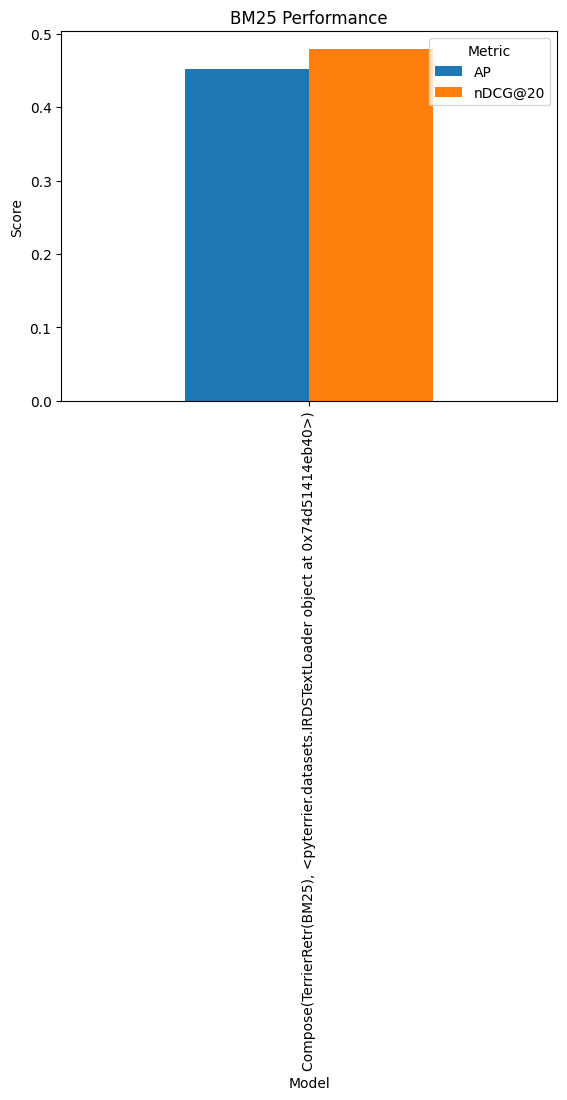

In [8]:
#experimento de recuperación
results = pt.Experiment(
    [bm25],
    dataset.get_topics(),
    dataset.get_qrels(),
    [MAP, nDCG@20]
)

print(results)


print("Column names:", results.columns)

plt.figure(figsize=(10, 6))
metric_columns = [col for col in results.columns if col not in ['name', 'query']]
results.plot(x='name', y=metric_columns, kind='bar')
plt.title('BM25 Performance')
plt.xlabel('Model')
plt.ylabel('Score')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

# Prueba del modelo con una consulta

In [9]:
from IPython.display import display, HTML

#query de prueba
sample_query = "capital of france"
results = bm25.search(sample_query)

print("Results for the query:", sample_query)

print("Shape of results:", results.shape)
print("First few rows of results:")
print(results.head())

# Create a function to display results with scrollable text
def display_results_with_scroll(df, max_rows=5):
    df_html = df.to_html(index=False, classes='table table-striped')
    display(HTML(f"""
    <style>
        .scrollable-cell {{
            max-height: 100px;
            overflow-y: auto;
        }}
    </style>
    {df_html.replace('<td>', '<td class="scrollable-cell">')}
    """))

# Display results without the index, and with scrollable text
display_results_with_scroll(results[['rank', 'query', 'text']].head(5))

Results for the query: capital of france
Shape of results: (1000, 7)
First few rows of results:
  qid   docid      docno  rank      score              query  \
0   1    3887  1379520_2     0  18.772981  capital of france   
1   1  160566  1182771_7     1  17.947606  capital of france   
2   1   42629  4034012_0     2  16.782848  capital of france   
3   1   33301  1786215_2     3  16.174941  capital of france   
4   1   33299  1786215_0     4  15.382640  capital of france   

                                                text  
0  It's more liberal because it's population is m...  
1  lots of times people want to be the first to a...  
2  Berlin is the Capital of Germany.. . It as als...  
3  Capitalization means proprely using capital le...  
4  capitalization is when you get money (also kno...  


rank,query,text
0,capital of france,"It's more liberal because it's population is more open mined and accepting than any other city or state in the USA. San Francisco is known by many as 'The American Paris'. Paris France is the Gay Capital of the world, San Francisco is the Gay Capital of the USA. The world could learn many valuable lessons from both places."
1,capital of france,lots of times people want to be the first to answer so they can collect on the ten points. think about a question such as what is the capital of france. if they do not hurry up some one else will get and they they will loose out on their ten points. lol but u know some of us are loosers.
2,capital of france,"Berlin is the Capital of Germany.. . It as also the Capital before Germany was split in 2. . After WWII The Soviets got East Berlin (which became the Capital of East German) and America, Britian and France got portions of West Berlin.. . West Berlin went under West German rule although until 1991 the American, British and French sectors still existed in West Berlin (meaning those countries still had some authority in their sectors but they relinquished it months after East and West Germany reunited)."
3,capital of france,Capitalization means proprely using capital letters. Capitalism is an economic philosophy.
4,capital of france,"capitalization is when you get money (also known as capital) for your stuff (also known as assets). SO if you ahev a car, and you capitalize it, you'll have whatever the car is worth."
